In [ ]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install -q numpy==1.20.0
!pip install -q cellpose 
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob

from tqdm.auto import tqdm
import tifffile
import matplotlib.pyplot as plt
import random

## Visualising Flows
#### 5-fold data Generated in cellpose format here: https://www.kaggle.com/ks2019/sartorius-train-tif

In [2]:
HOME = os.path.join('/home/ubuntu/kaggle-sartorius/')
RAW_DATA = os.path.join(HOME,'data/raw')
INTERIM_DATA = os.path.join(HOME,'data/interim')
PROCESSED_DATA = os.path.join(HOME,'data/processed')

TRAIN_CSV  = os.path.join(RAW_DATA,'train.csv')  
TRAIN_PATH = os.path.join(RAW_DATA,'train')  
TEST_PATH  = os.path.join(RAW_DATA,'test')  
MODELS_PATH = os.path.join(HOME,'models')
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = MODELS_PATH

e201f565a7d8_img.tif


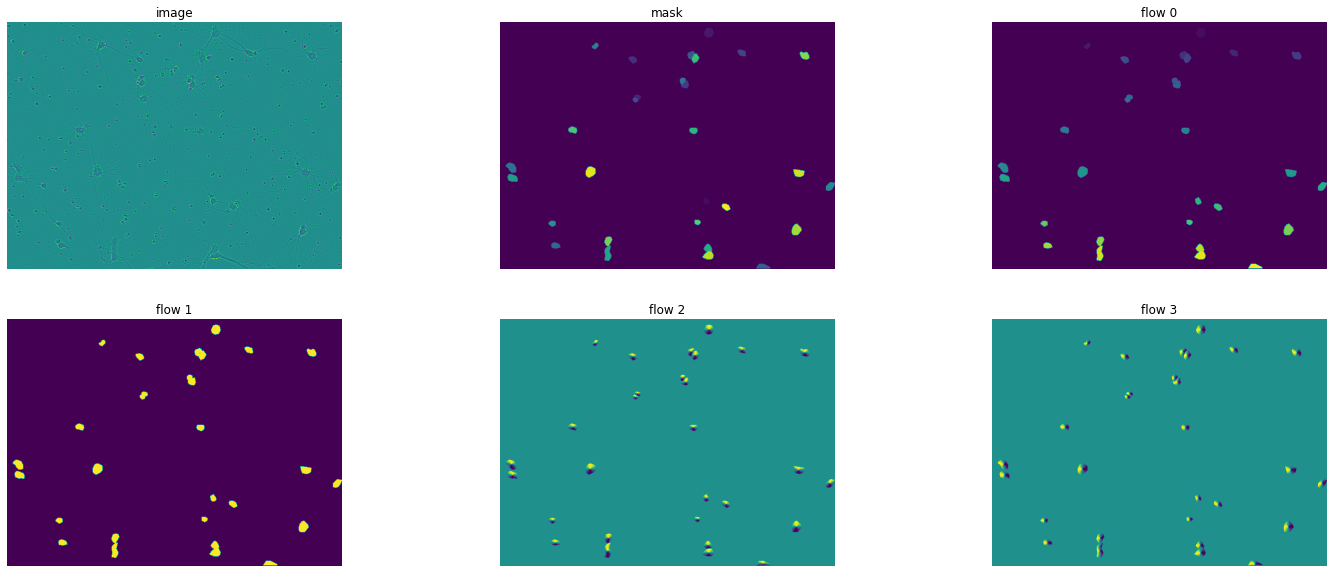

c0b82bc0600d_img.tif


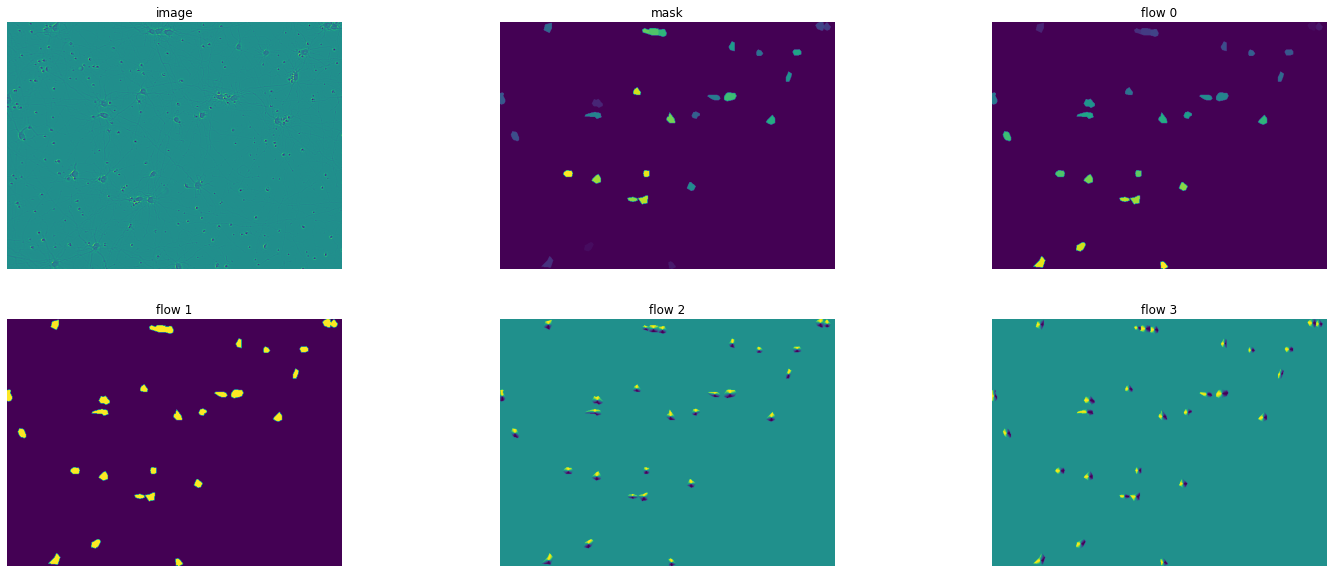

7f27bcdc5e5d_img.tif


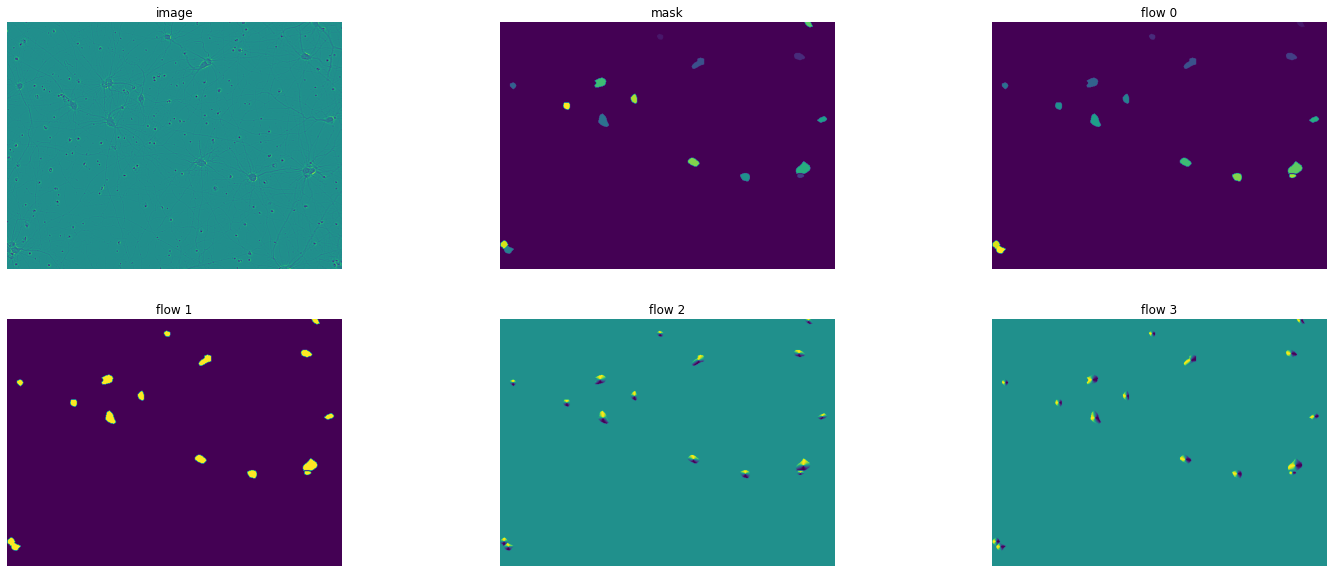

b307d66eb656_img.tif


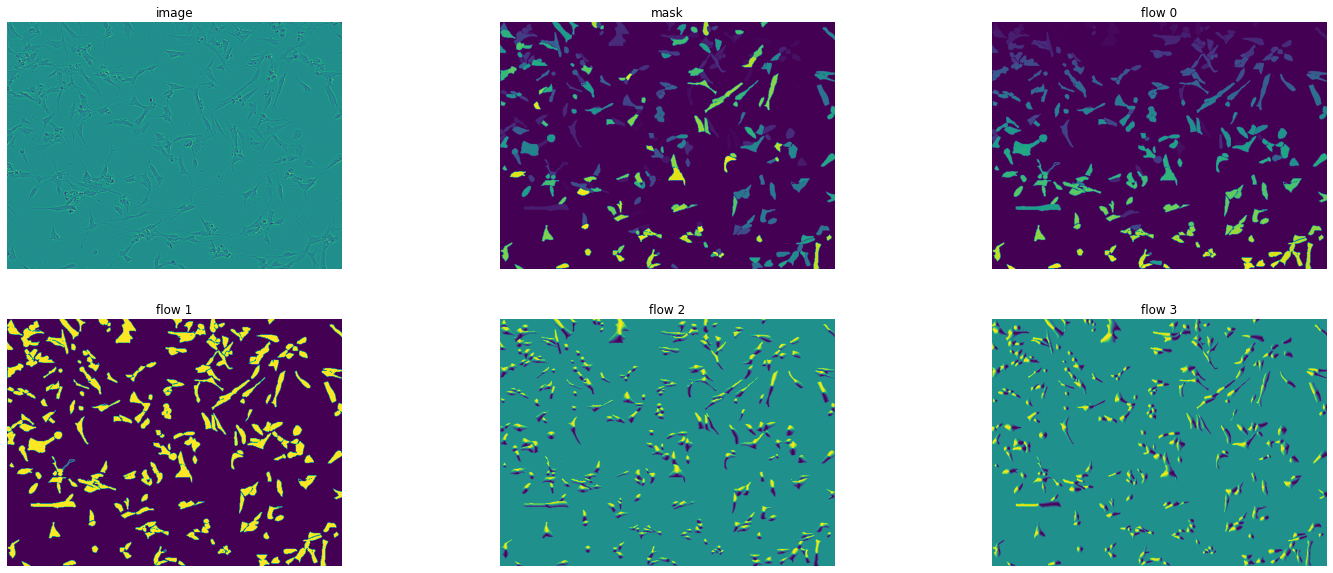

7b27ca965a93_img.tif


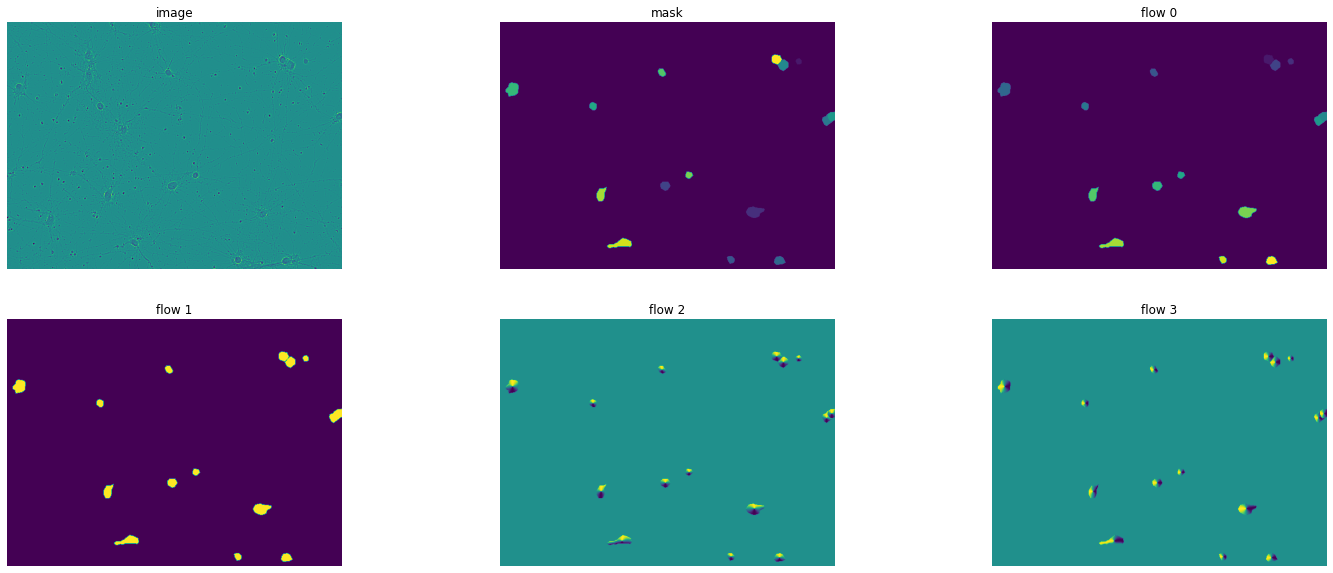

In [3]:
def plot_example(img_path):
    mask_path = img_path.replace('img','masks')
    flow_path = img_path.replace('img','flows')
    img = tifffile.imread(img_path)
    masks = tifffile.imread(mask_path)
    flows = tifffile.imread(flow_path)

    plt.figure(figsize=(25,10))
    plt.subplot(2,3,1)
    plt.axis('off')
    plt.imshow(img)
    plt.title('image')
    plt.subplot(2,3,2)
    plt.axis('off')
    plt.imshow(masks)
    plt.title('mask')
    for k in range(4):
        plt.subplot(2,3,3+k)
        plt.axis('off')
        plt.imshow(flows[k])
        plt.title(f'flow {k}')
    plt.show()
    
root = os.path.join(RAW_DATA,'sartorius-train-tif','fold_0','train/') 
sample_paths = os.listdir(root)
sample_paths = [x for x in sample_paths if 'img' in x]
random.shuffle(sample_paths)
for k in range(5):
    img_path = sample_paths[k]
    print(img_path)
    plot_example(root+img_path)

## Train

In [13]:
model_to_load = 'cyto' ## cyto, cyto2, nuclei
number_of_epochs = 100  ## Train more epochs for better results
batch_size = 8
initial_learning_rate = 0.0001
Training_channel = 0 # For grayscale
Second_training_channel= 0 
train_folder = '/tmp/cellpose_train/train'
test_folder = '/tmp/cellpose_train/val'
FOLD = 2

In [14]:
!rm -rf /tmp

rm: cannot remove '/tmp/systemd-private-d83de7219b1c4effa908ec1cf9ee984f-systemd-resolved.service-pxoqsj': Operation not permitted
rm: cannot remove '/tmp/.ICE-unix': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d83de7219b1c4effa908ec1cf9ee984f-systemd-timesyncd.service-lb2jsg': Operation not permitted
rm: cannot remove '/tmp/.XIM-unix': Operation not permitted
rm: cannot remove '/tmp/.X11-unix': Operation not permitted
rm: cannot remove '/tmp/systemd-private-d83de7219b1c4effa908ec1cf9ee984f-systemd-logind.service-qp86jf': Operation not permitted
rm: cannot remove '/tmp/.Test-unix': Operation not permitted
rm: cannot remove '/tmp/.font-unix': Operation not permitted
rm: cannot remove '/tmp/snap.lxd': Operation not permitted
rm: cannot remove '/tmp/glances-root.log': Operation not permitted


In [15]:
!mkdir -p /tmp/cellpose_train/

root = os.path.join(RAW_DATA,'sartorius-train-tif')
!cp -r {root}/fold_{FOLD}/* /tmp/cellpose_train/

In [16]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

1455
363


In [17]:
!python -m cellpose \
        --train \
        --use_gpu \
        --fast_mode \
        --dir "$train_folder" --test_dir "$test_folder" \
        --pretrained_model $model_to_load \
        --chan $Training_channel --chan2 $Second_training_channel \
        --n_epochs $number_of_epochs \
        --learning_rate $initial_learning_rate \
        --batch_size $batch_size \
        --img_filter img \
        --mask_filter masks

2021-12-27 15:57:20,110 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
2021-12-27 15:57:21,382 [INFO] ** TORCH CUDA version installed and working. **
2021-12-27 15:57:21,383 [INFO] >>>> using GPU
Not all flows are present. Run flow generation again.
Not all flows are present. Run flow generation again.
2021-12-27 15:57:21,903 [INFO] >>>> pretrained model /home/ubuntu/kaggle-sartorius/models/cytotorch_0 is being used
2021-12-27 15:57:21,903 [INFO] >>>> during training rescaling images to fixed diameter of 30.0 pixels
2021-12-27 15:57:22,025 [INFO] Training with rescale = 1.00
2021-12-27 15:57:26,203 [INFO] train channels = 2
2021-12-27 15:57:27,252 [INFO] test channels = 2
2021-12-27 15:57:27,253 [INFO] NOTE: computing flows for labels (could be done before to save time)
100%|█████████████████████████████████████████| 485/485 [00:59<00:00,  8.16it/s]
2021-12-27 15:58:29,444 [INFO] NOTE: computing flows for labels (could be done before to save time)
100%|████████████████████

In [30]:
!ls -lh /tmp/cellpose_train/train/models

total 26M
-rw-r--r-- 1 ubuntu ubuntu 26M Dec 27 16:12 cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_59_40.275145


In [31]:
!cp -r /tmp/cellpose_train/train/models .

## Inference 

Refer: https://www.kaggle.com/slawekbiel/cellpose-inference-307-lb

In [33]:
glob.glob('models/*')

['models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_14_44_48.894719',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_14_27.361131',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_13_49_29.004444',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_14_25_20.668245',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_33_25.249923',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_00_26.054643',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_59_40.275145',
 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_21_43.338759']

In [34]:
##----------Update this Manually
model_path = 'models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_59_40.275145'
print(model_path)

models/cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_59_40.275145


In [35]:
%%writefile predict.py
import sys
import numpy as np
from cellpose import models, io, plot
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import glob

USE_GPU_FOR_INFERENCE = True

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_files = glob.glob('/tmp/cellpose_train/val/*_img.tif')
print(len(test_files))
model = models.CellposeModel(gpu=USE_GPU_FOR_INFERENCE, pretrained_model=sys.argv[1])

ids, masks = [],[]
for fn in tqdm(test_files):
    id_ = fn.split('/')[-1].replace('_img.tif','')
    preds, flows, _ = model.eval(io.imread(fn), diameter=19, channels=[0,0], augment=True, resample=True)
    for i in range (1, preds.max() + 1):
        ids.append(id_)
        masks.append(rle_encode(preds == i))
        
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('val_predictions.csv', index=False)

Overwriting predict.py


In [ ]:
!python predict.py {model_path} /tmp/cellpose_train/val

2021-12-27 16:16:21,755 [INFO] WRITING LOG OUTPUT TO /home/ubuntu/.cellpose/run.log
121
2021-12-27 16:16:21,882 [INFO] parsing model string cellpose_residual_on_style_on_concatenation_off_train_2021_12_27_15_59_40.275145 to get cellpose options
2021-12-27 16:16:23,089 [INFO] ** TORCH CUDA version installed and working. **
2021-12-27 16:16:23,090 [INFO] >>>> using GPU
  7%|██▊                                        | 8/121 [00:08<01:44,  1.08it/s]/home/ubuntu/.local/lib/python3.8/site-packages/cellpose/models.py:636: RuntimeWarning: overflow encountered in exp
  flows = [plot.dx_to_circ(dP,transparency=transparency,mask=1-1/(1+np.exp(dist))), dP, dist, bd, p, tr]
 77%|████████████████████████████████▎         | 93/121 [01:23<00:23,  1.19it/s]

## Plot

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import skimage
import skimage.segmentation
import matplotlib.pyplot as plt

In [ ]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

In [ ]:
width = 704
height = 520
shape = [height,width]

train_df = pd.read_csv(TRAIN_CSV)
train_df = train_df.groupby('id').annotation.agg(list).reset_index()

cellpose_predictions = pd.read_csv('val_predictions.csv')
cellpose_predictions = cellpose_predictions.groupby('id').predicted.agg(list).reset_index()
df = pd.merge(train_df,cellpose_predictions,on='id')

print(df.shape)

df.sample(2)

In [ ]:
for i,row in df.iterrows():
    
    print(row.id)
    gt_masks = rles_to_mask(row.annotation, shape).astype(np.uint16)
    predicted_masks = rles_to_mask(row.predicted, shape).astype(np.uint16)
    
    gt_masks = (gt_masks>0).astype(int)*(gt_masks%5)
    predicted_masks = (predicted_masks>0).astype(int)*(predicted_masks%5)

    _, axs = plt.subplots(1, 2, figsize=(36, 18))
    axs = axs.flatten()
    axs[0].imshow(gt_masks)
    axs[1].imshow(predicted_masks)
    plt.show()
    
    if i==4: break

## Evaluate

In [ ]:
def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array [n_truths x n_preds]): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) >= 1  # Correct objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

from tqdm.auto import tqdm
def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [
        compute_iou(rles_to_mask(truth,shape), rles_to_mask(pred,shape)) 
            for truth, pred in tqdm(zip(truths, preds))
    ]
    
    if verbose:
        print(ious[0].shape)
        print("Thresh\tTP\tFP\tFN\tPrecision\tRecall")

    prec = []
    recalls = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps)
        r = tps / (tps + fns)
        prec.append(p)
        recalls.append(r)
   
        if verbose:
            print("{:1.2f}\t{}\t{}\t{}\t{:1.3f}\t{:1.3f}".format(t, tps, fps, fns, p, r))

    if verbose:
        print("AP\t-\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return round(np.mean(prec),4)

In [ ]:
annotations = df.annotation.values
predictions = df.predicted.values

In [ ]:
iou_map(annotations,predictions,verbose=1)

## Tracking perf. 
### fold-2  
epochs=10, BS=8
iou=0.3543  
Epoch 9, Time 85.6s, Loss 0.5771, Loss Test 0.5457, LR 0.000  
----
epochs=50, BS=8
iou=0.3818  
Epoch 40, Time 313.2s, Loss 0.4704, Loss Test 0.4716, LR 0.0002
##### Increasing epochs 10-->50, increases IoU by 7.7%
##### Reducing BS from 8--->4 doesn't make any difference
